<a href="https://colab.research.google.com/github/Yash-Kamtekar/Deep_learning_assignment_1/blob/main/Black_Box_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#hide
#skip
! [ -e /content ] && pip install -Uqq fastai  # upgrade fastai on colab

# cnn_learner for Image Classification

> Using the fastai library in computer vision.

In [2]:
from fastai.vision.all import *

For this task, we will use the Pet Dataset that contains images of cats and dogs of 37 different breeds. We will first show how to build a simple cat-vs-dog classifier, then a little bit more advanced model that can classify all breeds.

The dataset can be downloaded and decompressed with this line of code:

In [3]:
path = untar_data(URLs.PETS)

It will only do this download once, and return the location of the decompressed archive. We can check what is inside with the `.ls()` method.

In [4]:
path.ls()

(#2) [Path('/root/.fastai/data/oxford-iiit-pet/annotations'),Path('/root/.fastai/data/oxford-iiit-pet/images')]

We will ignore the annotations folder for now, and focus on the images one. `get_image_files` is a fastai function that helps us grab all the image files (recursively) in one folder.

In [5]:
files = get_image_files(path/"images")
len(files)

7390

To label our data for the cats vs dogs problem, we need to know which filenames are of dog pictures and which ones are of cat pictures. There is an easy way to distinguish: the name of the file begins with a capital for cats, and a lowercased letter for dogs:

In [6]:
files[0],files[6]

(Path('/root/.fastai/data/oxford-iiit-pet/images/basset_hound_124.jpg'),
 Path('/root/.fastai/data/oxford-iiit-pet/images/Birman_74.jpg'))

We can then define an easy label function:

In [7]:
def label_func(f): return f[0].isupper()

To get our data ready for a model, we need to put it in a `DataLoaders` object. Here we have a function that labels using the file names, so we will use `ImageDataLoaders.from_name_func`. There are other factory methods of `ImageDataLoaders` that could be more suitable for your problem, so make sure to check them all in `vision.data`. 

In [8]:
dls = ImageDataLoaders.from_name_func(path, files, label_func, item_tfms=Resize(224))

We have passed to this function the directory we're working in, the `files` we grabbed, our `label_func` and one last piece as `item_tfms`: this is a `Transform` applied on all items of our dataset that will resize each image to 224 by 224, by using a random crop on the largest dimension to make it a square, then resizing to 224 by 224. If we didn't pass this, we would get an error later as it would be impossible to batch the items together.

We can then check if everything looks okay with the `show_batch` method (`True` is for cat, `False` is for dog):

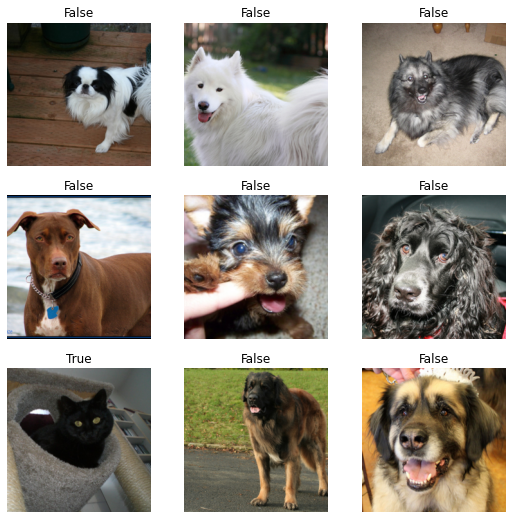

In [9]:
dls.show_batch()

Then we can create a `Learner`, which is a fastai object that combines the data and a model for training, and uses transfer learning to fine tune a pretrained model in just two lines of code:

In [10]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.152730,0.016775,0.004736,01:21


epoch,train_loss,valid_loss,error_rate,time
0,0.060877,0.017531,0.004736,01:33


The first line downloaded a model called ResNet34, pretrained on [ImageNet](http://www.image-net.org/), and adapted it to our specific problem. It then fine tuned that model and in a relatively short time, we get a model with an error rate of 0.3%... amazing!

If you want to make a prediction on a new image, you can use `learn.predict`:

In [11]:
learn.predict(files[0])

('False', TensorBase(0), TensorBase([9.9998e-01, 2.3291e-05]))

The predict method returns three things: the decoded prediction (here `False` for dog), the index of the predicted class and the tensor of probabilities of all classes in the order of their indexed labels(in this case, the model is quite confifent about the being that of a dog). This method accepts a filename, a PIL image or a tensor directly in this case.
We can also have a look at some predictions with the `show_results` method:

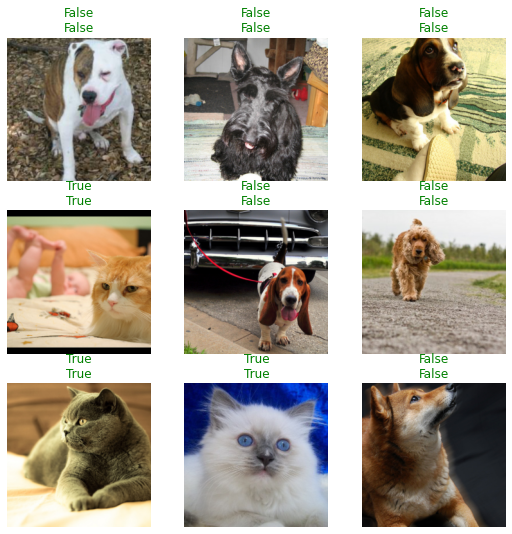

In [12]:
learn.show_results()

# unet_learner for Segmentation

Segmentation is a problem where we have to predict a category for each pixel of the image. For this task, we will use the Camvid dataset, a dataset of screenshots from cameras in cars. Each pixel of the image has a label such as "road", "car" or "pedestrian".

As usual, we can download the data with our `untar_data` function.

In [13]:
path = untar_data(URLs.CAMVID_TINY)
path.ls()

(#3) [Path('/root/.fastai/data/camvid_tiny/codes.txt'),Path('/root/.fastai/data/camvid_tiny/images'),Path('/root/.fastai/data/camvid_tiny/labels')]

The `images` folder contains the images, and the corresponding segmentation masks of labels are in the `labels` folder. The `codes` file contains the corresponding integer to class (the masks have an int value for each pixel). 

In [14]:
codes = np.loadtxt(path/'codes.txt', dtype=str)
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car',
       'CartLuggagePram', 'Child', 'Column_Pole', 'Fence', 'LaneMkgsDriv',
       'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving',
       'ParkingBlock', 'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk',
       'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel',
       'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

### Segmentation - Using the high-level API

As before, the `get_image_files` function helps us grab all the image filenames:

In [15]:
fnames = get_image_files(path/"images")
fnames[0]

Path('/root/.fastai/data/camvid_tiny/images/Seq05VD_f04650.png')

Let's have a look in the labels folder:

In [16]:
(path/"labels").ls()[0]

Path('/root/.fastai/data/camvid_tiny/labels/Seq05VD_f02940_P.png')

It seems the segmentation masks have the same base names as the images but with an extra `_P`, so we can define a label function: 

In [17]:
def label_func(fn): return path/"labels"/f"{fn.stem}_P{fn.suffix}"

We can then gather our data using `SegmentationDataLoaders`:

In [18]:
dls = SegmentationDataLoaders.from_label_func(
    path, bs=8, fnames = fnames, label_func = label_func, codes = codes
)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


We do not need to pass `item_tfms` to resize our images here because they already are all of the same size.

As usual, we can have a look at our data with the `show_batch` method. In this instance, the fastai library is superimposing the masks with one specific color per pixel:

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


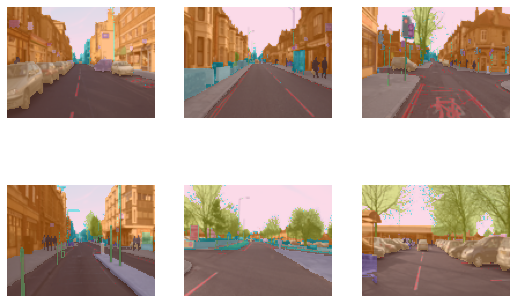

In [19]:
dls.show_batch(max_n=6)

A traditional CNN won't work for segmentation, we have to use a special kind of model called a UNet, so we use `unet_learner` to define our `Learner`:

In [20]:
learn = unet_learner(dls, resnet34)
learn.fine_tune(6)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


epoch,train_loss,valid_loss,time
0,2.946002,2.844894,00:13


epoch,train_loss,valid_loss,time
0,2.219736,1.775451,00:05
1,1.859344,1.529592,00:04
2,1.668770,1.260443,00:04
3,1.498930,1.095098,00:04
4,1.366576,1.045619,00:04
5,1.266554,1.028732,00:04


And as before, we can get some idea of the predicted results with `show_results`

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


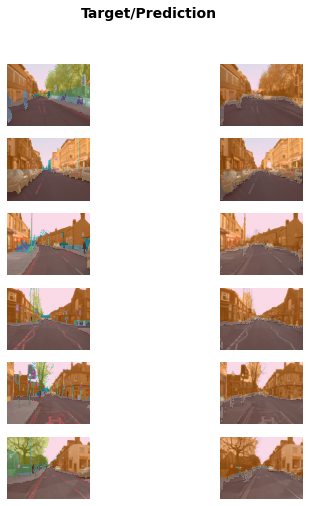

In [21]:
learn.show_results(max_n=6, figsize=(7,8))

We can also sort the model's errors on the validation set using the `SegmentationInterpretation` class and then plot the instances with the `k` highest contributions to the validation loss.

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


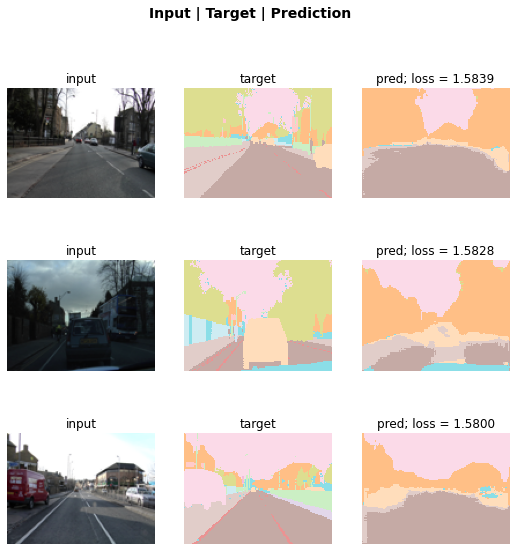

In [22]:
interp = SegmentationInterpretation.from_learner(learn)
interp.plot_top_losses(k=3)

# text_classifier_learner for Sentiment Analysis

In [23]:
from fastai.text.all import *

dls = TextDataLoaders.from_folder(untar_data(URLs.IMDB), valid='test')
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy)
learn.fine_tune(4, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.455447,0.399930,0.816240,09:56


epoch,train_loss,valid_loss,accuracy,time
0,0.310830,0.273577,0.888880,19:08
1,0.249978,0.266883,0.887840,19:09
2,0.200598,0.195475,0.924240,19:10
3,0.144859,0.189154,0.929920,19:09


In [24]:
learn.predict("I really liked that movie!")

('pos', TensorText(1), TensorText([0.0061, 0.9939]))

# tabular_learner for Decisiontree

In [25]:
from fastai.text.all import *

dls = TextDataLoaders.from_folder(untar_data(URLs.IMDB), valid='test')
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy)
learn.fine_tune(4, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.464409,0.395640,0.823520,09:53


epoch,train_loss,valid_loss,accuracy,time
0,0.313286,0.270574,0.892240,19:09
1,0.238006,0.206756,0.920320,19:08
2,0.188794,0.200134,0.924920,19:08
3,0.140577,0.198071,0.927200,19:07


In [26]:
learn.predict("I really liked that movie!")

('pos', TensorText(1), TensorText([9.4152e-05, 9.9991e-01]))

#collab_learner for Ranking

In [27]:
from fastai.collab import *
path = untar_data(URLs.ML_SAMPLE)
dls = CollabDataLoaders.from_csv(path/'ratings.csv')
learn = collab_learner(dls, y_range=(0.5,5.5))
learn.fine_tune(10)

epoch,train_loss,valid_loss,time
0,1.509373,1.428804,00:00


epoch,train_loss,valid_loss,time
0,1.358099,1.372518,00:00
1,1.262628,1.200688,00:00
2,1.036398,0.895168,00:00
3,0.813170,0.742150,00:00
4,0.697548,0.702694,00:00
5,0.650551,0.688290,00:00
6,0.627822,0.681834,00:00
7,0.616447,0.678841,00:00
8,0.603060,0.677927,00:00
9,0.607037,0.677742,00:00


In [28]:
learn.show_results()

,userId,movieId,rating,rating_pred
0,30.0,7.0,5.0,4.533172
1,8.0,24.0,3.0,3.573749
2,36.0,79.0,4.5,4.154050
3,21.0,96.0,3.5,3.409139
4,44.0,6.0,4.0,4.165305
5,73.0,67.0,4.0,3.811219
6,11.0,84.0,4.0,3.504814
7,28.0,6.0,2.5,3.116053
8,28.0,56.0,3.5,3.127519
